In [1]:
import sys
import os
import numpy as np

In [2]:
from DiffusionAnalysis.loaders import DatDirectoryStructureLoader
from DiffusionAnalysis.trajectory import DisplacementTrajectory
from DiffusionAnalysis.analysis import SimpleMSDAnalysis

In [3]:
loader = DatDirectoryStructureLoader('dat_directory', structures_slice=None)

Loading slice None from 2562 files


In [4]:
traj = DisplacementTrajectory(loader, timestep=0.1, time_unit='ps')

Estimated memory usage: 658.32 MB


In [5]:
traj.generate_displacement_trajectory(host_atoms=['H'], show_progress=True)

Generating displacement trajectory: 100%|██████████| 2562/2562 [00:46<00:00, 55.36it/s]

Completed with memory usage: 598.48 MB


In [6]:
print(traj.displacement_trajectory[0,:,:])

#sum each timestep to get total displacement
total_displacement = traj.displacement_trajectory.sum(axis=1)
print(total_displacement[0])

#print the traj.displacement_trajectory nbytes in mb
print(traj.displacement_trajectory.nbytes/1e6)
print(traj._check_memory_usage())


[[ 0.          0.          0.        ]
 [-0.11774234 -0.13203753  0.06987852]
 [-0.14976144 -0.03061354  0.11958607]
 ...
 [-0.27328575  0.20327391  0.04019691]
 [-0.19601184 -0.23319532  0.10238233]
 [ 0.02838275 -0.28824645  0.23367449]]
[-1.10146986 -1.44043363 -0.94690364]
627.546528
Estimated memory usage: 658.32 MB
None


In [7]:
loader.reset()

atoms0 = next(loader)
for i in range(8):
    atoms2 = next(loader)

atoms10 = next(loader)

print(atoms0.get_scaled_positions()[0])
print(atoms10.get_scaled_positions()[0])

print(atoms10.get_scaled_positions()[0]- atoms0.get_scaled_positions()[0] )

[5.60220e-02 9.99870e-01 6.08254e-04]
[0.0556052 0.996558  0.00257  ]
[-0.0004168  -0.003312    0.00196175]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/rt/xr_hqkfs0sz5mrr3y_twkckh0000gn/T/ipykernel_96970/665788118.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/var/folders/rt/xr_hqkfs0sz5mrr3y_twkckh0000gn/T/ipykernel_96970/665788118.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()
/var/folders/rt/xr_hqkfs0sz5mrr3y_twkckh0000gn/T/ipykernel_96970/665788118.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig3.show()


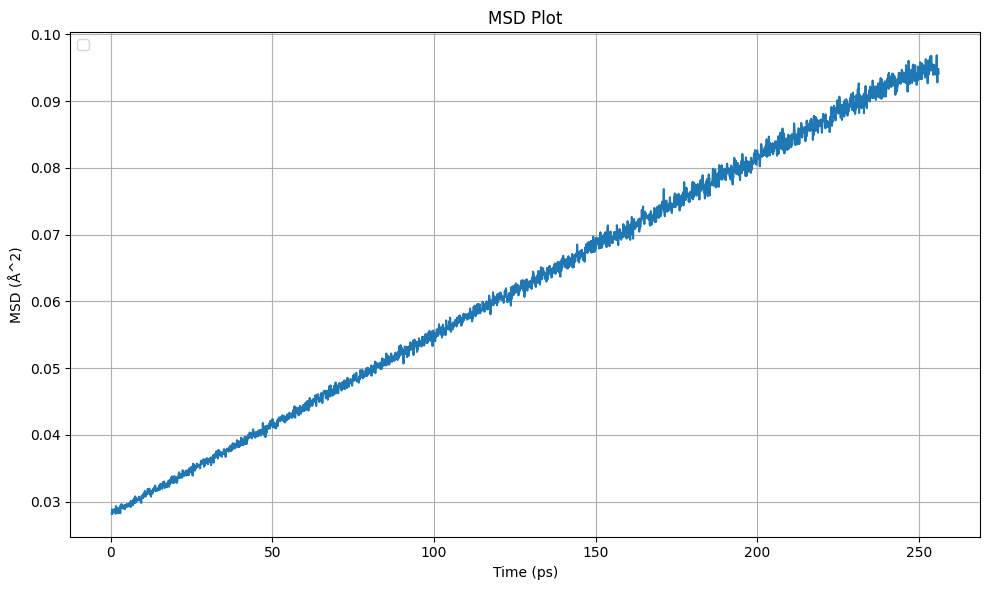

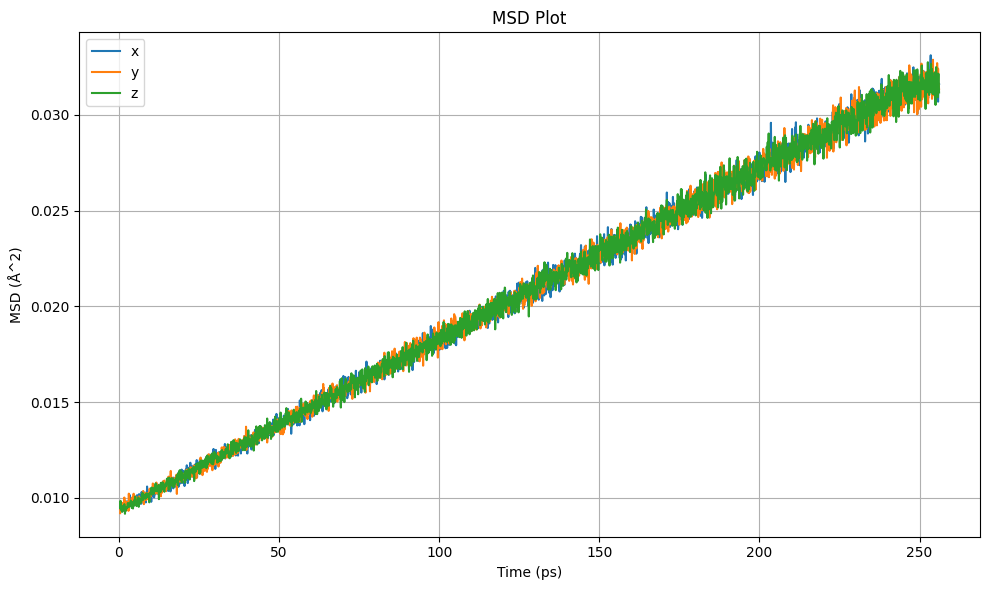

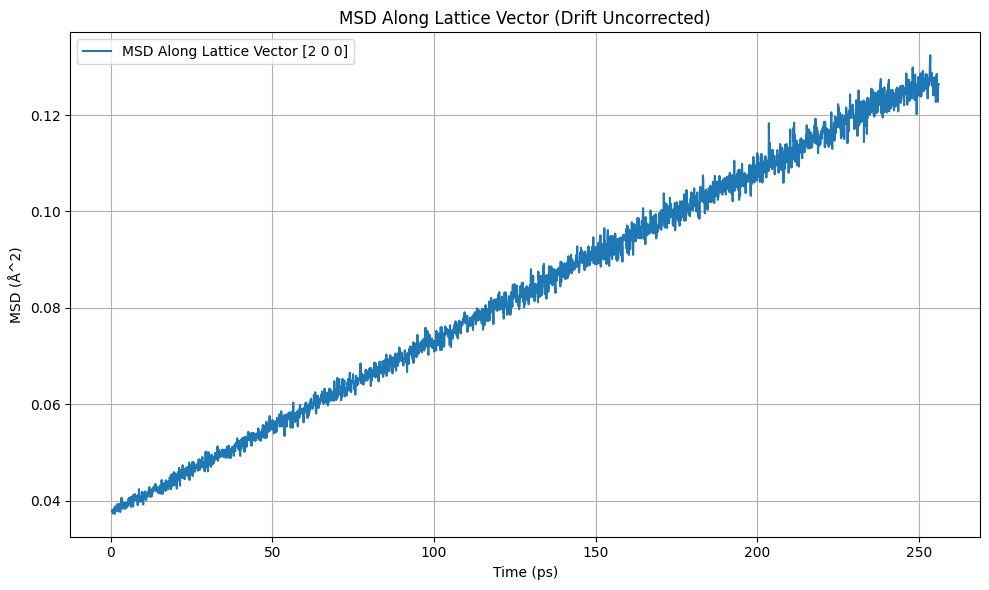

In [8]:
# Create an MSDAnalysis object
msd_analysis = SimpleMSDAnalysis(traj)

# Assuming you have an instance of SimpleMSDAnalysis called 'msd_analysis'

# Calculate the 3D MSD
msd_3d = msd_analysis.calculate_msd(return_3d_msd=True)
fig1 = msd_analysis.plot_msd((msd_3d), title='MSD Plot', legend_loc='upper left', skip_points=4)
fig1.show()
# Calculate the MSD for each direction (x, y, z)
msd_x, msd_y, msd_z = msd_analysis.calculate_msd(return_3d_msd=False)

# Plot the MSD for each direction
fig2 = msd_analysis.plot_msd((msd_x, msd_y, msd_z), labels=['x','y' ,'z'], title='MSD Plot', legend_loc='upper left', skip_points=4)
fig2.show()
# Calculate and plot the MSD along a non-normalized lattice vector for host atoms, correcting for framework drift
lattice_vector = np.array([2, 0, 0])  # Example non-normalized lattice vector
msd_along_lattice = msd_analysis.calculate_msd_along_lattice_vector(lattice_vector, atom_indices=msd_analysis.displacement_trajectory.host_atom_indices, correct_drift=False)
fig3 = msd_analysis.plot_msd(msd_along_lattice, labels=f'MSD Along Lattice Vector {lattice_vector}', title='MSD Along Lattice Vector (Drift Uncorrected)', skip_points=4)
fig3.show()

Calculating Van Hove: 100%|██████████| 16275168/16275168 [00:00<00:00, 16527795.61it/s]


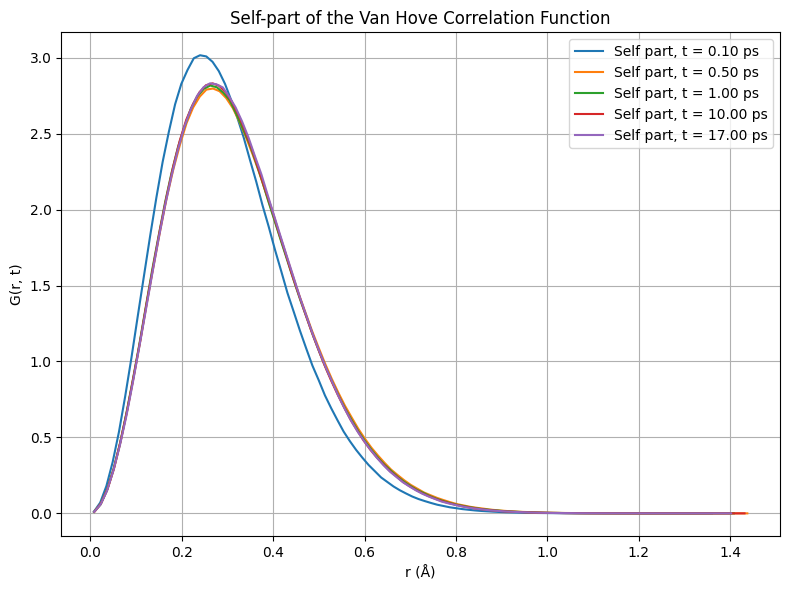

Calculating Van Hove: 100%|██████████| 17316180/17316180 [00:01<00:00, 16375803.05it/s]


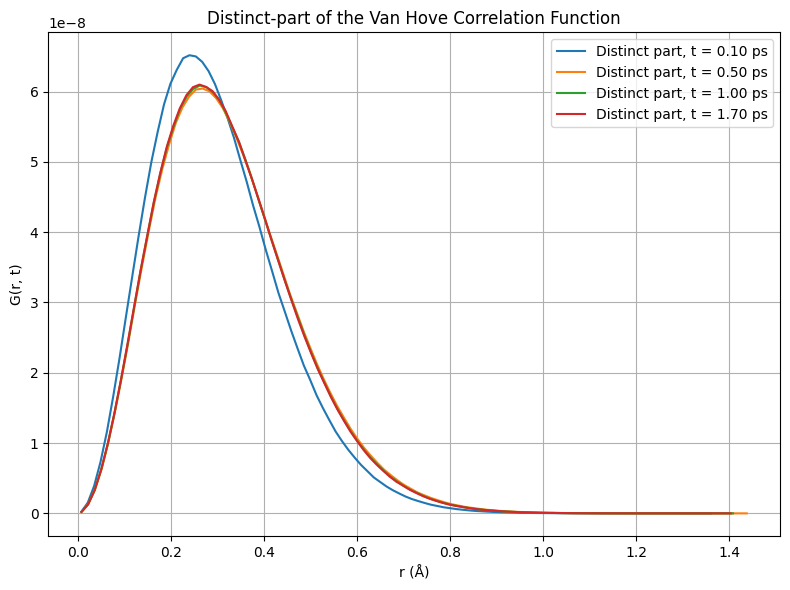

In [9]:
from DiffusionAnalysis.analysis import VanHoveAnalysis
import numpy as np
import matplotlib.pyplot as plt


# Create a VanHoveAnalysis object
van_hove_analyzer = VanHoveAnalysis(traj)

# Set the parameters for the analysis
tau_values = [1, 5, 10, 100, 500]  # Time lags in number of timesteps
r_range = (0, 10)  # Range of distances to consider
n_bins = 100  # Number of bins for the histogram

self_data = []
for tau in tau_values:
    bin_centers, hist = van_hove_analyzer.calculate_van_hove(tau, r_range, n_bins,
                                                             mode='self', )
    self_data.append((bin_centers, hist, tau))

# Plot the self-part of the van Hove correlation function
self_fig = van_hove_analyzer.plot_van_hove(self_data, mode='self', title='Self-part of the Van Hove Correlation Function')
plt.show()

distinct_data = []
for tau in tau_values:
    bin_centers_distinct, hist_distinct = van_hove_analyzer.calculate_van_hove(tau, r_range, n_bins, mode='distinct')
    distinct_data.append((bin_centers_distinct, hist_distinct, tau))

# Plot the distinct-part of the van Hove correlation function
distinct_fig = van_hove_analyzer.plot_van_hove(distinct_data, mode='distinct', title='Distinct-part of the Van Hove Correlation Function')
plt.show()
